In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os
import plotly.express as px
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tabulate
import plotly.graph_objects as go

In [2]:
os.chdir('..')

In [3]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.utils import missing_values_table, find_agg, convert_bytes_to_megabytes, fix_outlier, remove_outliers
from src.plot_utils import set_seaborn_style, plot_histogram_kde, plot_boxplot, plot_time_series, plot_countplot, create_table

In [4]:
db_connection = DatabaseConnection()
set_seaborn_style()

In [5]:
db_connection.connect()

Connected to the database.


In [6]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [7]:
# Check for missing values in the original DataFrame df
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [8]:
grouped_data = df.groupby('MSISDN/Number')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()

# Treat missing values by replacing them with the mean
grouped_data['TCP DL Retrans. Vol (Bytes)'].fillna(grouped_data['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)

# Handling outliers (you can use a different method if needed)
mean_value = grouped_data['TCP DL Retrans. Vol (Bytes)'].mean()
std_dev = grouped_data['TCP DL Retrans. Vol (Bytes)'].std()

# Define a threshold for outliers (you can adjust this threshold)
outlier_threshold = 3

# Replace outliers with the mean value
grouped_data['TCP DL Retrans. Vol (Bytes)'] = grouped_data['TCP DL Retrans. Vol (Bytes)'].apply(
    lambda x: mean_value if abs(x - mean_value) > outlier_threshold * std_dev else x
)

# Display the resulting DataFrame
print(grouped_data)

        MSISDN/Number  TCP DL Retrans. Vol (Bytes)
0        3.360100e+10                 1.685339e+07
1        3.360100e+10                 1.685339e+07
2        3.360100e+10                 1.685339e+07
3        3.360101e+10                 1.066000e+03
4        3.360101e+10                 9.349630e+06
...               ...                          ...
106851   3.379000e+10                 2.150440e+05
106852   3.379000e+10                 1.685339e+07
106853   3.197021e+12                 1.685339e+07
106854   3.370000e+14                 1.685339e+07
106855   8.823971e+14                 1.685339e+07

[106856 rows x 2 columns]


In [9]:
 grouped_data_rtt = df.groupby('MSISDN/Number')['Avg RTT DL (ms)'].mean().reset_index()

# Treat missing values by replacing them with the mean
grouped_data_rtt['Avg RTT DL (ms)'].fillna(grouped_data_rtt['Avg RTT DL (ms)'].mean(), inplace=True)

# Handling outliers (you can use a different method if needed)
mean_value_rtt = grouped_data_rtt['Avg RTT DL (ms)'].mean()
std_dev_rtt = grouped_data_rtt['Avg RTT DL (ms)'].std()

# Define a threshold for outliers (you can adjust this threshold)
outlier_threshold_rtt = 3

# Replace outliers with the mean value
grouped_data_rtt['Avg RTT DL (ms)'] = grouped_data_rtt['Avg RTT DL (ms)'].apply(
    lambda x: mean_value_rtt if abs(x - mean_value_rtt) > outlier_threshold_rtt * std_dev_rtt else x
)

# Display the resulting DataFrame
print(grouped_data_rtt)

        MSISDN/Number  Avg RTT DL (ms)
0        3.360100e+10        46.000000
1        3.360100e+10        30.000000
2        3.360100e+10       119.182869
3        3.360101e+10        69.000000
4        3.360101e+10        57.000000
...               ...              ...
106851   3.379000e+10        42.000000
106852   3.379000e+10        34.000000
106853   3.197021e+12       119.182869
106854   3.370000e+14       119.182869
106855   8.823971e+14       119.182869

[106856 rows x 2 columns]


In [10]:
grouped_data_handset = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index()

# Treat missing values by replacing them with the mode
grouped_data_handset['Handset Type'].fillna(grouped_data_handset['Handset Type'].mode().iat[0], inplace=True)

# Display the resulting DataFrame
print(grouped_data_handset)

        MSISDN/Number                      Handset Type
0        3.360100e+10    Huawei P20 Lite Huawei Nova 3E
1        3.360100e+10            Apple iPhone 7 (A1778)
2        3.360100e+10                         undefined
3        3.360101e+10           Apple iPhone 5S (A1457)
4        3.360101e+10           Apple iPhone Se (A1723)
...               ...                               ...
106851   3.379000e+10               Huawei Honor 9 Lite
106852   3.379000e+10       Apple iPhone 8 Plus (A1897)
106853   3.197021e+12  Quectel Wireless. Quectel Ec25-E
106854   3.370000e+14                  Huawei B525S-23A
106855   8.823971e+14  Quectel Wireless. Quectel Ec21-E

[106856 rows x 2 columns]


In [11]:
# Group by customer and calculate the mean for both DL and UL throughput
grouped_data_throughput = df.groupby('MSISDN/Number').agg({
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# Treat missing values by replacing them with the mean
grouped_data_throughput['Avg Bearer TP DL (kbps)'].fillna(grouped_data_throughput['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
grouped_data_throughput['Avg Bearer TP UL (kbps)'].fillna(grouped_data_throughput['Avg Bearer TP UL (kbps)'].mean(), inplace=True)

# Display the resulting DataFrame
print(grouped_data_throughput)

        MSISDN/Number  Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)
0        3.360100e+10                     37.0                     39.0
1        3.360100e+10                     48.0                     51.0
2        3.360100e+10                     48.0                     49.0
3        3.360101e+10                    204.0                     44.0
4        3.360101e+10                  20197.5                   8224.5
...               ...                      ...                      ...
106851   3.379000e+10                   9978.0                    387.0
106852   3.379000e+10                     68.0                     48.0
106853   3.197021e+12                      1.0                      0.0
106854   3.370000e+14                     11.0                     22.0
106855   8.823971e+14                      2.0                      0.0

[106856 rows x 3 columns]


In [27]:
# Top 10 TCP values
top_10_tcp_values = grouped_data['TCP DL Retrans. Vol (Bytes)'].nlargest(10)

# Bottom 10 TCP values
bottom_10_tcp_values = grouped_data['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)

# Most frequent TCP values
most_frequent_tcp_values = grouped_data['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

# Display the results
print("Top 10 TCP values:")
print(top_10_tcp_values)

print("\nBottom 10 TCP values:")
print(bottom_10_tcp_values)

print("\nMost frequent TCP values:")
print(most_frequent_tcp_values)

Top 10 TCP values:
69294     310515144.0
54457     310428913.0
40944     308987345.0
65225     305080248.2
98539     305032416.0
40381     302816124.0
38499     301424986.0
30210     300028359.0
100456    299789643.0
34234     299677295.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP values:
56622     2.0
95322     2.0
71705     4.0
71778     4.0
87156     4.0
87348     4.0
95213     4.0
95331     4.0
95774     4.0
100616    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most frequent TCP values:
TCP DL Retrans. Vol (Bytes)
1.685339e+07    58773
1.330000e+03      375
2.660000e+03      194
3.800000e+01      187
9.200000e+01      175
1.318000e+03      115
3.990000e+03      100
7.600000e+01       99
5.320000e+03       94
5.430000e+02       93
Name: count, dtype: int64


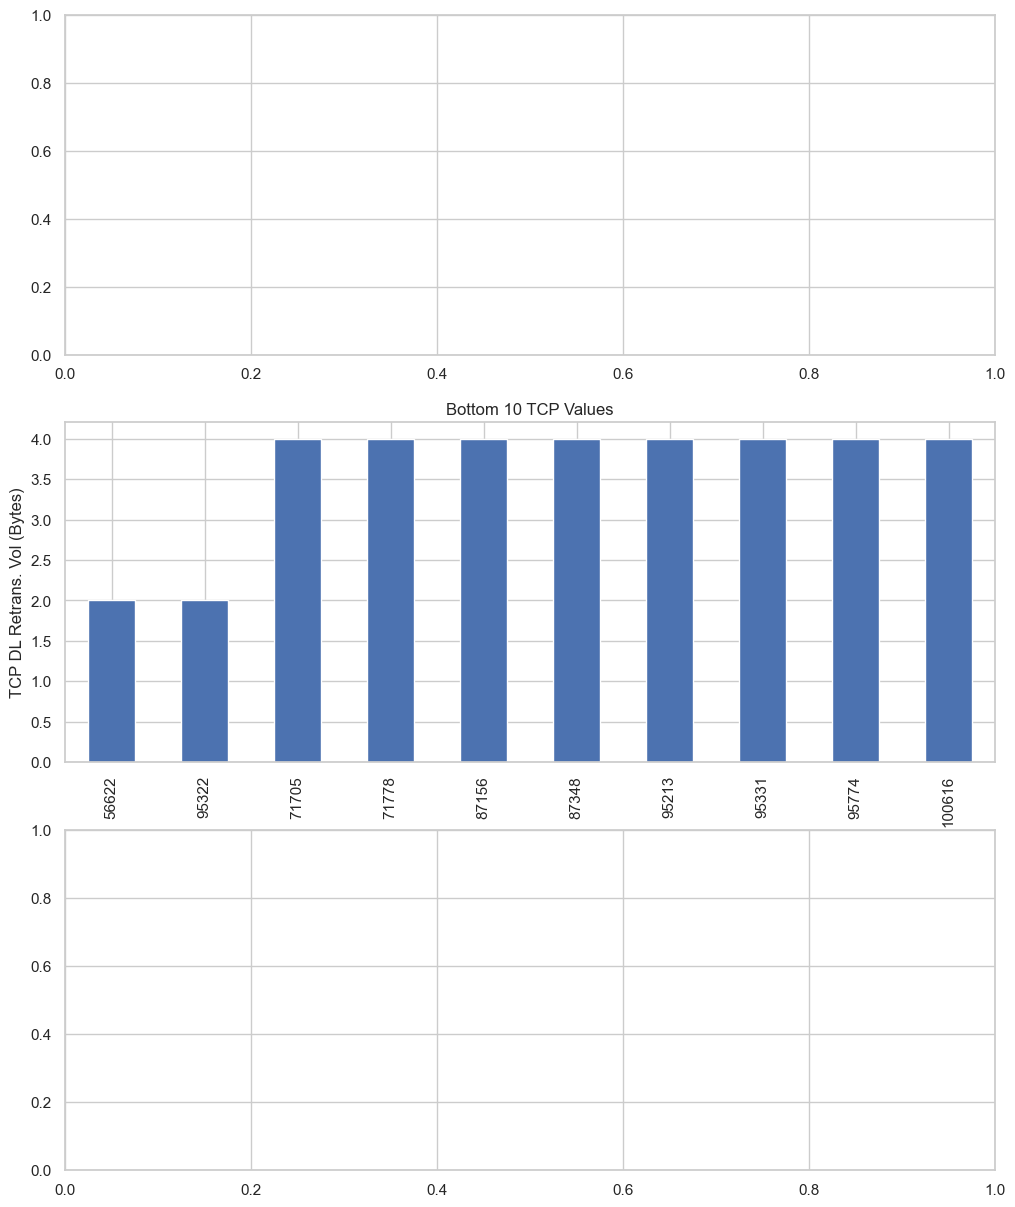

In [41]:


# Create separate DataFrames for each set of values
top_10_data = pd.DataFrame({'Top 10 TCP Values': top_10_tcp_values.values}, index=top_10_tcp_values.index)
bottom_10_data = pd.DataFrame({'Bottom 10 TCP Values': bottom_10_tcp_values.values}, index=bottom_10_tcp_values.index)
most_frequent_data = pd.DataFrame({'Frequency': most_frequent_tcp_values.values}, index=most_frequent_tcp_values.index)
# Remove the specified data point from the most frequent TCP values
most_frequent_tcp_values = most_frequent_tcp_values[~(most_frequent_tcp_values.index == "16853393.739320666")]
# Plotting using Matplotlib
fig, axes = plt.subplots(3, 1, figsize=(12, 15))


# Plot Bottom 10 TCP Values
bottom_10_data.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_ylabel('TCP DL Retrans. Vol (Bytes)')
axes[1].set_title('Bottom 10 TCP Values')


# Show the plot
plt.show()

In [40]:
# Plot Bottom 10 TCP Values
bottom_10_data.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_ylabel('TCP DL Retrans. Vol (Bytes)')
axes[1].set_title('Bottom 10 TCP Values')

# Plot Most Frequent TCP Values
most_frequent_data.plot(kind='bar', ax=axes[2], legend=False)
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Most Frequent TCP Values')

# Show the plot
plt.show()

In [30]:
data

,Top 10 TCP Values,Bottom 10 TCP Values,Frequency
69294,310515144.0,2.0,58773
54457,310428913.0,2.0,375
40944,308987345.0,4.0,194
65225,305080248.2,4.0,187
98539,305032416.0,4.0,175
40381,302816124.0,4.0,115
38499,301424986.0,4.0,100
30210,300028359.0,4.0,99
100456,299789643.0,4.0,94
34234,299677295.0,4.0,93


In [14]:
# Top 10 RTT values
top_10_rtt_values = grouped_data_rtt['Avg RTT DL (ms)'].nlargest(10)

# Bottom 10 RTT values
bottom_10_rtt_values = grouped_data_rtt['Avg RTT DL (ms)'].nsmallest(10)

# Most frequent RTT values
most_frequent_rtt_values = grouped_data_rtt['Avg RTT DL (ms)'].value_counts().head(10)

# Display the results
print("Top 10 RTT values:")
print(top_10_rtt_values)

print("\nBottom 10 RTT values:")
print(bottom_10_rtt_values)

print("\nMost frequent RTT values:")
print(most_frequent_rtt_values)

Top 10 RTT values:
82031    1869.0
22149    1867.0
3190     1865.0
42939    1865.0
66379    1862.0
95197    1858.0
38849    1854.0
59975    1853.0
66936    1852.0
72347    1848.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT values:
28878     0.0
40873     0.0
44748     0.0
66098     0.0
88903     0.0
98541     0.0
39066     2.0
83396     4.0
36039     5.0
106569    5.0
Name: Avg RTT DL (ms), dtype: float64

Most frequent RTT values:
Avg RTT DL (ms)
119.182869    19204
28.000000      2378
27.000000      2089
34.000000      1946
37.000000      1755
35.000000      1751
38.000000      1739
36.000000      1653
29.000000      1652
26.000000      1581
Name: count, dtype: int64


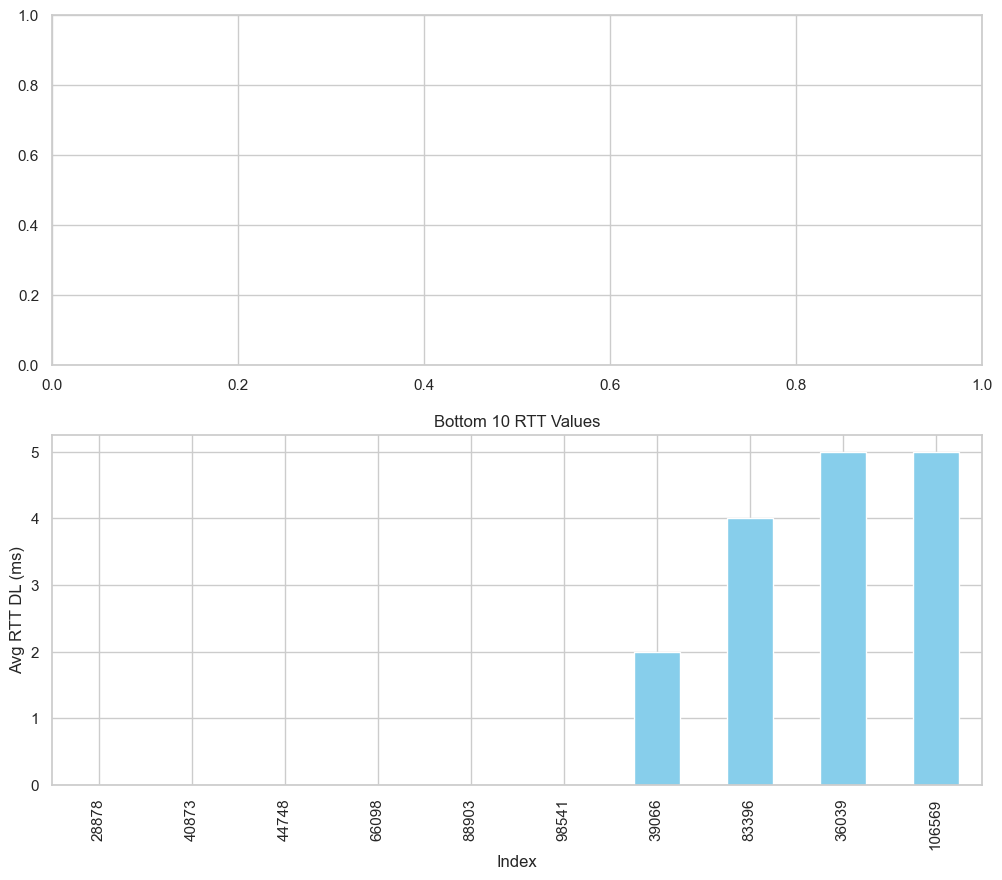

In [44]:
# Create separate DataFrames for each set of values
top_10_rtt_data = pd.DataFrame({'Top 10 RTT Values': top_10_rtt_values.values}, index=top_10_rtt_values.index)
bottom_10_rtt_data = pd.DataFrame({'Bottom 10 RTT Values': bottom_10_rtt_values.values}, index=bottom_10_rtt_values.index)

# Plotting using Matplotlib
fig, axes = plt.subplots(2, 1, figsize=(12, 10))


# Plot Bottom 10 RTT Values
bottom_10_rtt_data.plot(kind='bar', ax=axes[1], legend=False, color='skyblue')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Avg RTT DL (ms)')
axes[1].set_title('Bottom 10 RTT Values')

# Show the plot
plt.show()

In [15]:
# Top 10 throughput values (DL)
top_10_throughput_dl_values = grouped_data_throughput['Avg Bearer TP DL (kbps)'].nlargest(10)

# Bottom 10 throughput values (DL)
bottom_10_throughput_dl_values = grouped_data_throughput['Avg Bearer TP DL (kbps)'].nsmallest(10)

# Most frequent throughput values (DL)
most_frequent_throughput_dl_values = grouped_data_throughput['Avg Bearer TP DL (kbps)'].value_counts().head(10)

# Top 10 throughput values (UL)
top_10_throughput_ul_values = grouped_data_throughput['Avg Bearer TP UL (kbps)'].nlargest(10)

# Bottom 10 throughput values (UL)
bottom_10_throughput_ul_values = grouped_data_throughput['Avg Bearer TP UL (kbps)'].nsmallest(10)

# Most frequent throughput values (UL)
most_frequent_throughput_ul_values = grouped_data_throughput['Avg Bearer TP UL (kbps)'].value_counts().head(10)

# Display the results
print("Top 10 Throughput values (DL):")
print(top_10_throughput_dl_values)

print("\nBottom 10 Throughput values (DL):")
print(bottom_10_throughput_dl_values)

print("\nMost frequent Throughput values (DL):")
print(most_frequent_throughput_dl_values)

print("\nTop 10 Throughput values (UL):")
print(top_10_throughput_ul_values)

print("\nBottom 10 Throughput values (UL):")
print(bottom_10_throughput_ul_values)

print("\nMost frequent Throughput values (UL):")
print(most_frequent_throughput_ul_values)

Top 10 Throughput values (DL):
49595     264448.0
37838     245347.0
14564     236507.0
60763     230084.0
27722     225035.0
92374     223533.0
98280     223224.0
104697    218742.0
52298     211835.0
52830     209672.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Bottom 10 Throughput values (DL):
229     0.0
857     0.0
1094    0.0
1204    0.0
1434    0.0
1985    0.0
1992    0.0
2473    0.0
2605    0.0
2671    0.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Most frequent Throughput values (DL):
Avg Bearer TP DL (kbps)
23.0    4108
6.0     3062
43.0    2486
44.0    2087
22.0    1824
63.0    1637
48.0    1600
42.0    1575
47.0    1331
45.0    1144
Name: count, dtype: int64

Top 10 Throughput values (UL):
6542      58613.0
75465     53572.0
31624     49112.0
7606      48689.0
14596     48354.0
103604    48277.0
100302    47367.0
69920     47336.0
43785     46788.0
51990     46663.0
Name: Avg Bearer TP UL (kbps), dtype: float64

Bottom 10 Throughput values (UL):
230     0.0
349     

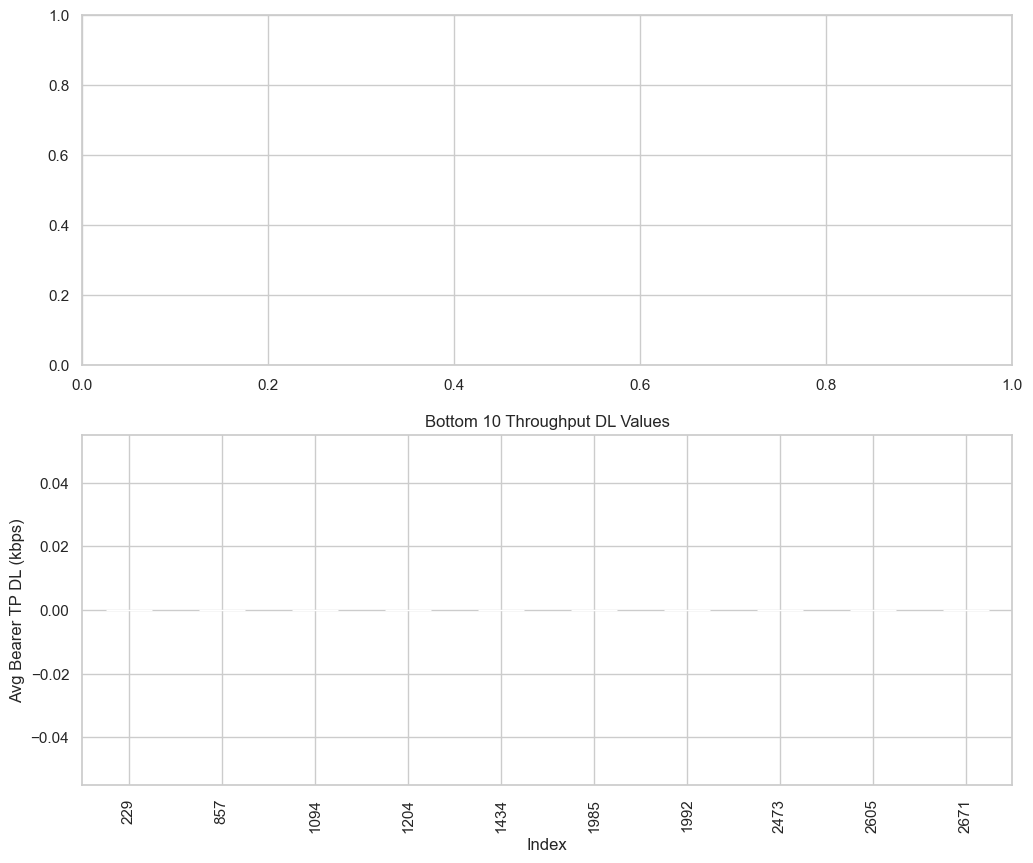

In [50]:
# Create separate DataFrames for each set of values
top_10_throughput_dl_data = pd.DataFrame({'Top 10 Throughput DL Values': top_10_throughput_dl_values.values}, index=top_10_throughput_dl_values.index)
bottom_10_throughput_dl_data = pd.DataFrame({'Bottom 10 Throughput DL Values': bottom_10_throughput_dl_values.values}, index=bottom_10_throughput_dl_values.index)

# Plotting using Matplotlib
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Bottom 10 Throughput DL Values
bottom_10_throughput_dl_data.plot(kind='bar', ax=axes[1], legend=False, color='purple')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Avg Bearer TP DL (kbps)')
axes[1].set_title('Bottom 10 Throughput DL Values')

# Show the plot
plt.show()

In [16]:
# Group by handset type and calculate the mean for both DL and UL throughput
grouped_throughput = df.groupby('Handset Type').agg({
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# Display the resulting DataFrame
print(grouped_throughput)

                                           Handset Type  \
0                            A-Link Telecom I. Cubot A5   
1                     A-Link Telecom I. Cubot Note Plus   
2                        A-Link Telecom I. Cubot Note S   
3                          A-Link Telecom I. Cubot Nova   
4                         A-Link Telecom I. Cubot Power   
...                                                 ...   
1391  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1392                          Zyxel Communicat. Lte7460   
1393                          Zyxel Communicat. Sbg3600   
1394                    Zyxel Communicat. Zyxel Wah7706   
1395                                          undefined   

      Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  
0                23184.000000                326.00000  
1                 6527.000000                172.00000  
2                 8515.000000                422.00000  
3                55667.000000                550.00000  
4     

In [17]:
# Merge the datasets on 'MSISDN/Number'
grouped_throughput_handset = pd.merge(grouped_data_handset, grouped_data_throughput, on='MSISDN/Number')

# Display the resulting DataFrame
print(grouped_throughput_handset)

grouped_throughput_handset = grouped_throughput_handset.groupby('Handset Type').agg({
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

# Display the resulting DataFrame
print(grouped_throughput_handset)

        MSISDN/Number                      Handset Type  \
0        3.360100e+10    Huawei P20 Lite Huawei Nova 3E   
1        3.360100e+10            Apple iPhone 7 (A1778)   
2        3.360100e+10                         undefined   
3        3.360101e+10           Apple iPhone 5S (A1457)   
4        3.360101e+10           Apple iPhone Se (A1723)   
...               ...                               ...   
106851   3.379000e+10               Huawei Honor 9 Lite   
106852   3.379000e+10       Apple iPhone 8 Plus (A1897)   
106853   3.197021e+12  Quectel Wireless. Quectel Ec25-E   
106854   3.370000e+14                  Huawei B525S-23A   
106855   8.823971e+14  Quectel Wireless. Quectel Ec21-E   

        Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  
0                          37.0                     39.0  
1                          48.0                     51.0  
2                          48.0                     49.0  
3                         204.0                     44.

In [18]:
# Merge the datasets on 'MSISDN/Number'
merged_data = pd.merge(grouped_data_handset, grouped_data, on='MSISDN/Number')

# Display the resulting DataFrame
print(merged_data)



        MSISDN/Number                      Handset Type  \
0        3.360100e+10    Huawei P20 Lite Huawei Nova 3E   
1        3.360100e+10            Apple iPhone 7 (A1778)   
2        3.360100e+10                         undefined   
3        3.360101e+10           Apple iPhone 5S (A1457)   
4        3.360101e+10           Apple iPhone Se (A1723)   
...               ...                               ...   
106851   3.379000e+10               Huawei Honor 9 Lite   
106852   3.379000e+10       Apple iPhone 8 Plus (A1897)   
106853   3.197021e+12  Quectel Wireless. Quectel Ec25-E   
106854   3.370000e+14                  Huawei B525S-23A   
106855   8.823971e+14  Quectel Wireless. Quectel Ec21-E   

        TCP DL Retrans. Vol (Bytes)  
0                      1.685339e+07  
1                      1.685339e+07  
2                      1.685339e+07  
3                      1.066000e+03  
4                      9.349630e+06  
...                             ...  
106851                 2.

In [19]:
# Group by 'MSISDN/Number' and calculate the mode for 'Handset Type'
grouped_data_handset = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index()

# Group by 'Handset Type' and calculate the mean for 'TCP DL Retrans. Vol (Bytes)'
grouped_data_tcp = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()

# Merge the datasets on 'Handset Type'
merged_data = pd.merge(grouped_data_handset, grouped_data_tcp, on='Handset Type')

# Display the resulting DataFrame
print(merged_data)

        MSISDN/Number                                    Handset Type  \
0        3.360100e+10                  Huawei P20 Lite Huawei Nova 3E   
1        3.360126e+10                  Huawei P20 Lite Huawei Nova 3E   
2        3.360127e+10                  Huawei P20 Lite Huawei Nova 3E   
3        3.360128e+10                  Huawei P20 Lite Huawei Nova 3E   
4        3.360137e+10                  Huawei P20 Lite Huawei Nova 3E   
...               ...                                             ...   
106851   3.378689e+10  Huawei Mate 9 Pro Porsche Design Huawei Mate 9   
106852   3.378712e+10                     Ddm Brands Llc Andy 5El Lte   
106853   3.378853e+10                Vivo Mobile Comm. Vivo Vivo X21A   
106854   3.197021e+12                Quectel Wireless. Quectel Ec25-E   
106855   8.823971e+14                Quectel Wireless. Quectel Ec21-E   

        TCP DL Retrans. Vol (Bytes)  
0                      2.623121e+06  
1                      2.623121e+06  
2        

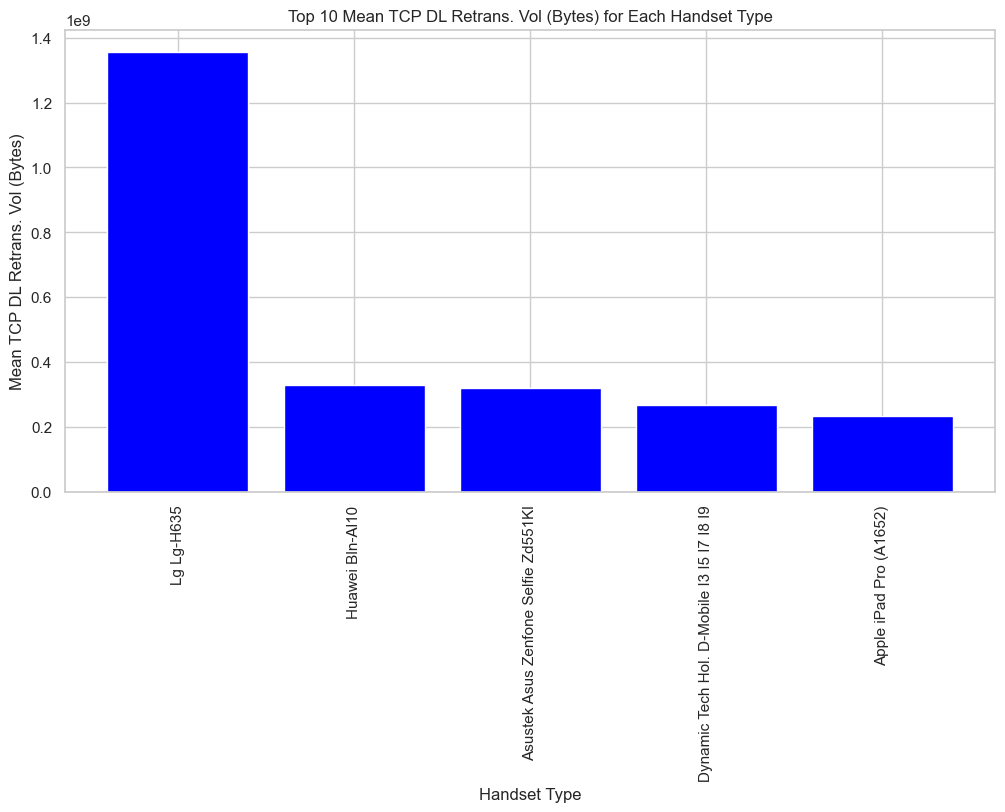

In [53]:
# Select the top 10 records based on mean TCP DL Retrans. Vol (Bytes)
top_10_mean_tcp_values = merged_data.nlargest(10, 'TCP DL Retrans. Vol (Bytes)')

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))

# Bar plot for top 10 mean TCP DL Retrans. Vol (Bytes) grouped by Handset Type
plt.bar(top_10_mean_tcp_values['Handset Type'], top_10_mean_tcp_values['TCP DL Retrans. Vol (Bytes)'], color='blue')

# Set labels and title
plt.xlabel('Handset Type')
plt.ylabel('Mean TCP DL Retrans. Vol (Bytes)')
plt.title('Top 10 Mean TCP DL Retrans. Vol (Bytes) for Each Handset Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [54]:
top_10_mean_tcp_values

,MSISDN/Number,Handset Type,TCP DL Retrans. Vol (Bytes)
106479,3.366610e+10,Lg Lg-H635,1.357279e+09
106480,3.368061e+10,Lg Lg-H635,1.357279e+09
106481,3.378009e+10,Lg Lg-H635,1.357279e+09
106496,3.366665e+10,Huawei Bln-Al10,3.290646e+08
106630,3.367591e+10,Asustek Asus Zenfone Selfie Zd551Kl,3.189534e+08
106631,3.376344e+10,Asustek Asus Zenfone Selfie Zd551Kl,3.189534e+08
106688,3.368795e+10,Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,2.672434e+08
106689,3.369879e+10,Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,2.672434e+08
106690,3.376276e+10,Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,2.672434e+08
105625,3.365811e+10,Apple iPad Pro (A1652),2.340550e+08
